# Complex Networks: with examples from Sea Surface Temperature

This notebook gives an example of how to generate complex networks of geospatial time series data using the python toolkit provided in this repository 'ComplexNetworks.py'.
The example here computes a network based on boreal winter (DJF) sea surface temperature anomalies. The data can be found at https://www.metoffice.gov.uk/hadobs/hadisst/.

In [3]:
import numpy as np
import ComplexNetworks as CN
from mpl_toolkits.basemap import Basemap
from scipy import stats
from netCDF4 import Dataset
from scipy.interpolate import griddata

%matplotlib inline

m = Basemap(projection='robin',lon_0=-180,resolution='l')

plot_lon,plot_lat = np.meshgrid(np.arange(0,362,2),np.arange(90,-90,-2))
plot_x,plot_y = m(plot_lon,plot_lat)

def readSST():
    SST = {}
    file = Dataset("./HadISST_sst.nc")

    data = np.array(file['sst']).transpose(1,2,0).reshape(180,360,12,2020-1870+1,order='F')
    data[data<0] = np.nan
    lon,lat = np.meshgrid(np.array(file['longitude']),np.array(file['latitude']))
    x,y = m(lon,lat)
    SST['lon'],SST['lat'] = np.meshgrid(np.arange(0,360,2),np.arange(90,-90,-2))
    xr,yr = m(SST['lon'],SST['lat'])

    DJF = np.zeros((90,180,2020-1900+1))
    for year in range(1900,2020+1):
        djf = np.nanmean([data[:,:,11,year-1-1870],data[:,:,0,year-1870],data[:,:,1,year-1870]],0)
        DJF[:,:,year-1900] = griddata((x.ravel(),y.ravel()),djf.ravel(),(xr,yr),'linear')
    SST['DJF'] = DJF
    return SST

def detrend():
    dX,dY,dT = SST['DJF'].shape
    detrended = np.zeros(SST['DJF'].shape)*np.nan
    trends = np.zeros((dX,dY,2))
    for i in range(dX):
        for j in range(dY):
            if ~np.isnan(SST['DJF'][i,j,:]).all():
                trend, intercept, r, p, std = stats.linregress(np.arange(dT),SST['DJF'][i,j,:])
                fit = trend*np.arange(dT) + intercept
                trends[i,j,0] = trend
                trends[i,j,1] = intercept
                detrended[i,j,:] = SST['DJF'][i,j,:] - fit

    SST['DJF_dt'] = detrended
    SST['DJF_trend'] = trend
        
def getNetwork():
    net = CN.Network(SST['DJF_dt'])
    CN.Network.get_threshold(net)
    CN.Network.get_nodes(net, latlon=True)
    CN.Network.get_links(net, lat=SST['lat'])
    SST['nodes'] = net.nodes
    SST['anomalies'] = net.anomaly
    SST['links'] = net.links
    SST['strength'] = net.strength
    SST['strengthmap'] = net.strengthmap
        

SST = readSST()
detrend()
getNetwork()

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/Users/williamgregory/Documents/ComplexNetworks.py:33: RuntimeWarning: All-NaN slice encountered
  ID = np.where(np.abs(np.nanmax(self.data,2))>0)
/Users/williamgregory/Documents/ComplexNetworks.py:33: RuntimeWarning: invalid value encountered in greater
  ID = np.where(np.abs(np.nanmax(self.data,2))>0)
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by

# Network visualisation

Here we show a number of ways to visualise the attributes of our complex network. On the one hand we can plot the 'strengthmap' which shows both the spatial extent of each network node, and the sum of the absolute value of each nodes link weights. The strongest nodes are therefore the leading modes of SST variability.

Similarly, we can plot similar information in a more typical network-based structure using python's networkx package (this requires installation). Here we can make the size of each node point propotional to the spatial extent of the area from which it covers, and then colour it according to its strength. We can then more easily visualise the network connectivity by red (positive covariance) and blue (negative covariance) links. The thickness of the links is then proportional to the covariance.

Finally, for a given node we can plot the temporal component of variability. Here we plot the time series associated with the strongest network node, which can be associated to the ENSO pattern of variability. The years marked in the plot here (1983,1998,20116) correspond to particularly strong ENSO years.

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iter

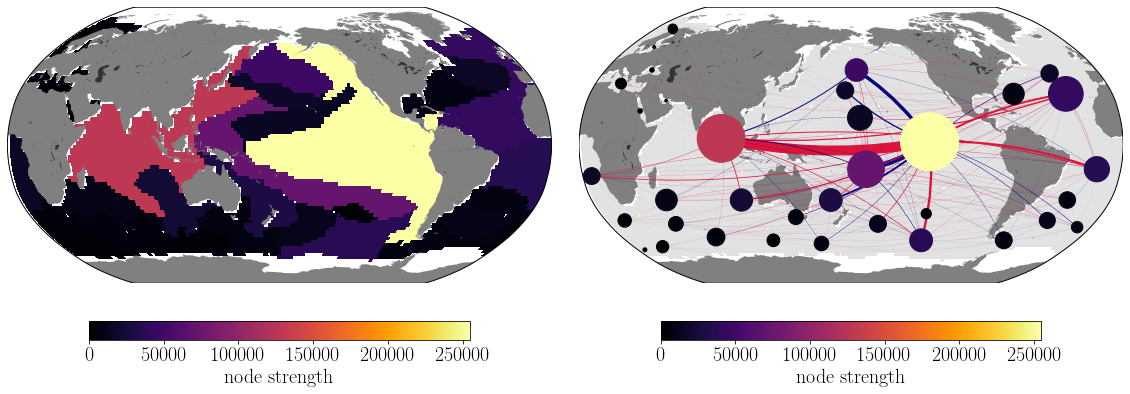

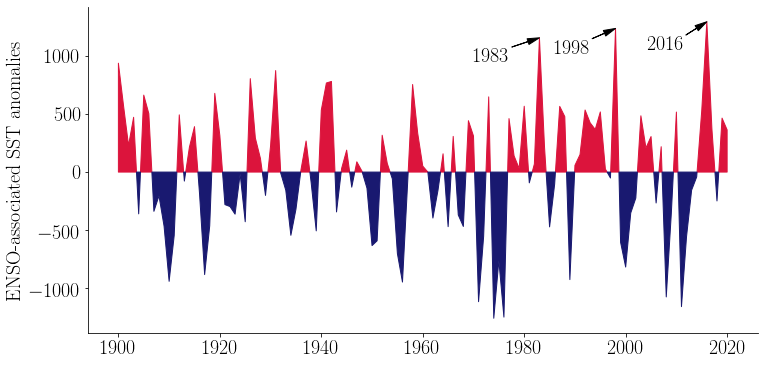

In [40]:
import networkx as nx
import matplotlib.cm as cm
import operator
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 20

def lat2area(lats,lons):
    """
    for a given latlon grid, calculate the area of each
    grid cell
    """
    r1 = 6378.137 #equatorial radius (km)
    r2 = 6356.752 #polar radius (km)
    
    dt_lat = abs(lats[0] - lats[1])
    dt_lon = abs(lons[0] - lons[1])
    
    Area = np.zeros(len(lats))
    for i in range(len(lats)-1):
        A1 = (lats[i]*np.pi)/180
        A2 = (lats[i+1]*np.pi)/180
        R = np.sqrt(((r1**2 * np.cos(A1))**2 + (r2**2 * np.sin(A1))**2)/((r1 * np.cos(A1))**2 + (r2 * np.sin(A1))**2))
        if abs(lats[i]) != 90:
            B = abs(np.sin(A1) - np.sin(A2))
            Area[i] = ((np.pi*R**2)/180)*B*dt_lon

    return Area

def makegraph(significance=0.1):
    graph = nx.DiGraph(directed=False)
    unavail = []
    unavail2 = []
    df = SST['DJF_dt'].shape[2] - 2
    for node1 in SST['nodes']:
        node_size = 0
        for cell in SST['nodes'][node1]:
            node_size += area[cell[0]]/2e4
        means = np.mean(SST['nodes'][node1],0)
        p = int(round(means[0])) ; q = int(round(means[1]))
        if node1 not in unavail:
            graph.add_node(node1, pos=(plot_x[p,q],plot_y[p,q]), color='black', size=node_size)
            unavail.append(node1)
        k = 0
        for node2 in SST['nodes']:
            node_size = 0
            for cell in SST['nodes'][node2]:
                node_size += area[cell[0]]/2e4
            means = np.mean(SST['nodes'][node2],0)
            p = int(round(means[0])) ; q = int(round(means[1]))
            if node2 not in unavail:
                graph.add_node(node2, pos=(plot_x[p,q],plot_y[p,q]), color='black', size=node_size)
                unavail.append(node2)
            edge = SST['links'][node1][k]
            R = edge/(np.std(SST['anomalies'][node1])*np.std(SST['anomalies'][node2]))
            tval = R*np.sqrt(df/(1 - R**2))
            P = stats.t.sf(abs(tval),df)
            if (P<significance) & (node1 != node2) & (node1 in graph.nodes()) & (node2 in graph.nodes()) & \
                    ([node2,node1] not in unavail2) & ([node1,node2] not in unavail2):
                if edge > 0:
                    graph.add_weighted_edges_from([(node1,node2,edge)], color='crimson', style='solid') 
                if edge < 0:
                    graph.add_weighted_edges_from([(node1,node2,edge)], color='navy', style='solid')
                unavail2.append([node1,node2])
                unavail2.append([node2,node1])
            k += 1
                
    edges = graph.edges()
    nodes = graph.nodes()
    node_size = [nx.get_node_attributes(graph, 'size')[n] for n in nodes]
    node_color = [cm.inferno(SST['strength'][n]/SST['strength'][maxstr]) for n in SST['strength']]
    edge_color = [graph[u][v]['color'] for u,v in edges]
    edge_style = [graph[u][v]['style'] for u,v in edges]
    weights = [graph[u][v]['weight'] for u,v in edges]
    minw = min(weights) ; maxw = max(weights)
    mw = max(abs(minw),abs(maxw))
    weights_scale = [(i/mw)*10 for i in weights]

    return graph,node_size,node_color,edge_color,weights_scale

area = lat2area(lons=np.arange(0,362,2),lats=np.arange(90,-90,-2))
#graph = makegraph()

fig,ax = plt.subplots(1,2,figsize=(20,10))
for c in range(2):
    m = Basemap(projection='robin',lon_0=-180,resolution='l',ax=ax[c])
    m.fillcontinents(color=(0.5, 0.5, 0.5),lake_color=(0.2, 0.2, 0.2))
    if c == 0:
        s = m.pcolormesh(plot_x,plot_y,SST['strengthmap'],cmap='inferno',vmin=0,rasterized=True)#,vmax=1.3e5,rasterized=True)
        #current_cmap = mpl.cm.get_cmap('YlGnBu_r')
        #current_cmap.set_over(color='black')
        cbar = fig.colorbar(s, ax=ax[c], orientation='horizontal',pad=0.07,fraction=0.035)
        cbar.set_label('node strength')
    else:
        outline = np.copy(SST['strengthmap'])
        outline[~np.isnan(outline)] = 0.8
        m.pcolormesh(plot_x,plot_y,outline,cmap='Greys_r',rasterized=True,vmin=0,vmax=1)
        maxstr = max(SST['strength'].items(), key=operator.itemgetter(1))[0]
        sm = plt.cm.ScalarMappable(cmap=cm.inferno, norm=plt.Normalize(vmin=0, vmax=SST['strength'][maxstr]))
        nx.draw(graph[0], pos=nx.get_node_attributes(graph[0], 'pos'), node_size=graph[1], node_color=graph[2],\
            edge_style='solid',edge_color=graph[3], width=graph[4], connectionstyle='arc3,rad=-0.1',arrowstyle='-')
        cbar = fig.colorbar(sm, ax=ax[c], orientation='horizontal',pad=0.07,fraction=0.035)
        cbar.set_label('node strength')
plt.subplots_adjust(wspace=0.05)
plt.show()

fig,ax = plt.subplots(1,figsize=(12,6))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.fill_between(np.arange(1900,2020+1),SST['anomalies'][maxstr],0,where=SST['anomalies'][maxstr]>=0,interpolate=True,color='crimson', rasterized=True)
ax.fill_between(np.arange(1900,2020+1),SST['anomalies'][maxstr],0,where=SST['anomalies'][maxstr]<=0,interpolate=True,color='midnightblue', rasterized=True)
ax.annotate('1983', xy=(1983, SST['anomalies'][maxstr][1983-1900]),  xycoords='data',
            xytext=(0.63, 0.875), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=0.1,headwidth=6),
            horizontalalignment='right', verticalalignment='top',
            )
ax.annotate('1998', xy=(1998, SST['anomalies'][maxstr][1998-1900]),  xycoords='data',
            xytext=(0.75, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=0.1,headwidth=6),
            horizontalalignment='right', verticalalignment='top',
            )
ax.annotate('2016', xy=(2016, SST['anomalies'][maxstr][2016-1900]),  xycoords='data',
            xytext=(0.89, 0.91), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=0.1,headwidth=6),
            horizontalalignment='right', verticalalignment='top',
            )
ax.set_ylabel('ENSO-associated SST anomalies')
plt.show()